# Data Set Source:

Sultana, Nusrat; Jahan, Musfika; Uddin, Mohammad Shorif (2022), “Fresh and Rotten Fruits Dataset for Machine-Based Evaluation of Fruit Quality”, Mendeley Data, V1, doi: 10.17632/bdd69gyhv8.1

# Package Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, RandomFlip, RandomRotation, Resizing
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from pathlib import Path

2024-02-19 21:12:08.822251: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 21:12:08.859004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:12:08.859039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:12:08.859763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 21:12:08.866556: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 21:12:08.867727: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Load Data Set


In [2]:
ProjPath = Path('.')
DataPath = ProjPath.joinpath('Data/Original_Image')

AugementedImagesPath = ProjPath.joinpath('Data/Augmented_Image')
LoggingPath = ProjPath.joinpath('Logs')

In [3]:
# Load data set
fruitData = tf.keras.utils.image_dataset_from_directory(DataPath)

classNames = fruitData.class_names
display(classNames)

Found 3200 files belonging to 16 classes.


['FreshApple',
 'FreshBanana',
 'FreshGrape',
 'FreshGuava',
 'FreshJujube',
 'FreshOrange',
 'FreshPomegranate',
 'FreshStrawberry',
 'RottenApple',
 'RottenBanana',
 'RottenGrape',
 'RottenGuava',
 'RottenJujube',
 'RottenOrange',
 'RottenPomegranate',
 'RottenStrawberry']

# Split Data set

- 70% -> training
- 20% -> validation
- 10% -> testing


In [4]:
trainingSize = int(len(fruitData) * 0.7)
validationSize = int(len(fruitData) * 0.2)
testingSize = int(len(fruitData) * 0.1)

trainingData = fruitData.take(trainingSize)
validationData = fruitData.skip(trainingSize).take(validationSize)
testingData = fruitData.skip(trainingSize + validationSize).take(testingSize)


print(f'Training data set size: {trainingSize}')
print(f'Validation data set size: {validationSize}')
print(f'Testing data set size: {testingSize}')


Training data set size: 70
Validation data set size: 20
Testing data set size: 10


# Add augmented data


In [5]:
# # concatenate augmented data to training data set
# augmentedFruitData = tf.keras.utils.image_dataset_from_directory(
#     AugementedImagesPath)
# trainingData_aug = trainingData.concatenate(augmentedFruitData).shuffle(buffer_size=5)
# print(
#     f'Training data set size with augmented data: {trainingData_aug.cardinality().numpy()}')

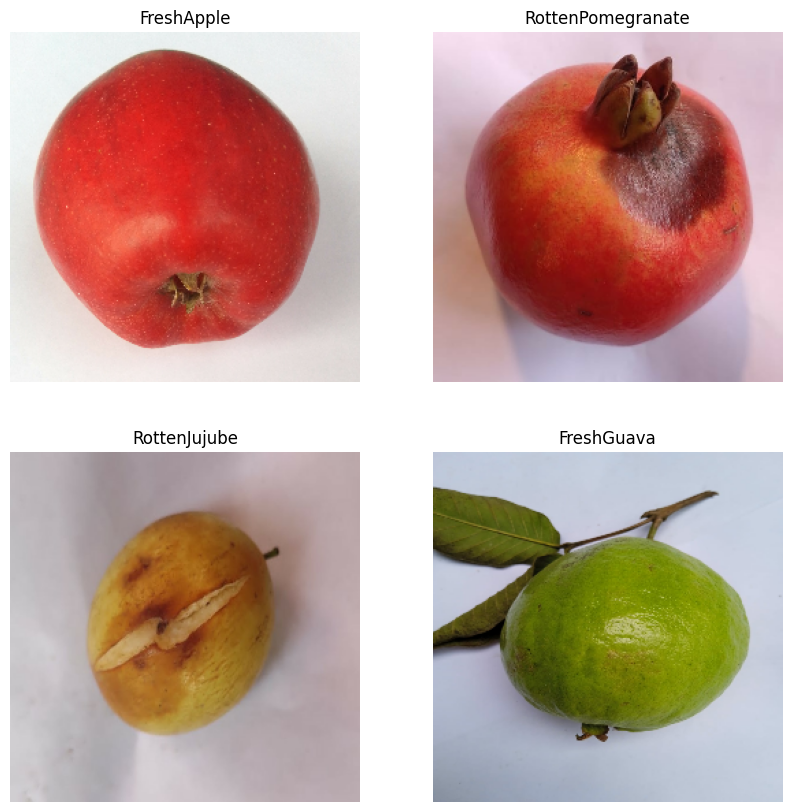

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in trainingData.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [7]:
trainingData

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Model Definition


In [8]:
# Define model
fruitFreshnessModel = Sequential([
    Rescaling(1./255, input_shape=(256, 256, 3)),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classNames), activation='sigmoid')
])

In [9]:
# Compile Model
fruitFreshnessModel.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics=['accuracy'])

In [10]:
fruitFreshnessModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4

# Add Logging


In [11]:
# Track model performance
tensorBoardInstance = TensorBoard(log_dir=LoggingPath)
earlyStopping = EarlyStopping(patience=5)

# Train Model


In [12]:
Epochs = 10

# Train on non augmented data
trainingHistory = fruitFreshnessModel.fit(trainingData, epochs=Epochs, validation_data=validationData, callbacks=[tensorBoardInstance, earlyStopping])

# Train on augmented data
# trainingHistory_aug = fruitFreshnessModel.fit(trainingData_aug, epochs=Epochs, validation_data=validationData, callbacks=[tensorBoardInstance, earlyStopping])

Epoch 1/10


70/70 [==============================] - 140s 2s/step - loss: 2.0919 - accuracy: 0.3223 - val_loss: 1.3144 - val_accuracy: 0.5828
Epoch 2/10
70/70 [==============================] - 136s 2s/step - loss: 1.1299 - accuracy: 0.6071 - val_loss: 1.0728 - val_accuracy: 0.6266
Epoch 3/10
70/70 [==============================] - 144s 2s/step - loss: 0.8840 - accuracy: 0.6862 - val_loss: 0.8158 - val_accuracy: 0.7328
Epoch 4/10
70/70 [==============================] - 140s 2s/step - loss: 0.7809 - accuracy: 0.7237 - val_loss: 0.8220 - val_accuracy: 0.7203
Epoch 5/10
70/70 [==============================] - 153s 2s/step - loss: 0.6657 - accuracy: 0.7661 - val_loss: 0.5817 - val_accuracy: 0.8141
Epoch 6/10
70/70 [==============================] - 141s 2s/step - loss: 0.5653 - accuracy: 0.7946 - val_loss: 0.7081 - val_accuracy: 0.7672
Epoch 7/10
70/70 [==============================] - 140s 2s/step - loss: 0.5210 - accuracy: 0.8098 - val_loss: 0.6227 - val_accuracy: 0.7906
Epoch 8/10
70/70 [======

# Performance Visualization


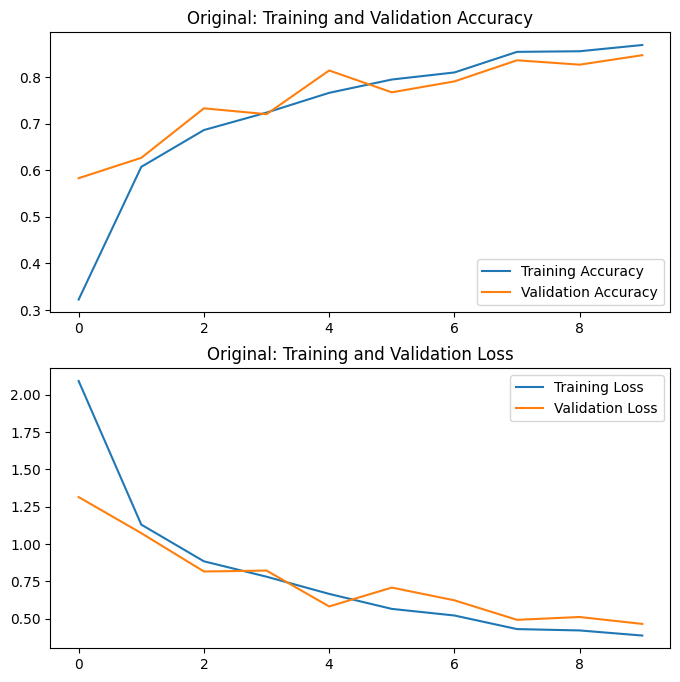

In [15]:
def plotMetrics(trainingHistory, dataTitle):
    acc = trainingHistory.history['accuracy']
    val_acc = trainingHistory.history['val_accuracy']

    loss = trainingHistory.history['loss']
    val_loss = trainingHistory.history['val_loss']

    epochs_range = range(Epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{dataTitle}: Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'{dataTitle}: Training and Validation Loss')
    plt.show()

plotMetrics(trainingHistory, 'Original')
# plotMetrics(trainingHistory_aug, 'Augmented')

# Testing Model with reserved Test data

In [16]:
loss, accuracy = fruitFreshnessModel.evaluate(testingData)
print(f'Loss: {loss} | Accuracy: {accuracy}')

10/10 [==============================] - 26s 213ms/step - loss: 0.5357 - accuracy: 0.8531
Loss: 0.5356704592704773 | Accuracy: 0.8531249761581421


1/1 [==============================] - 0s 30ms/step


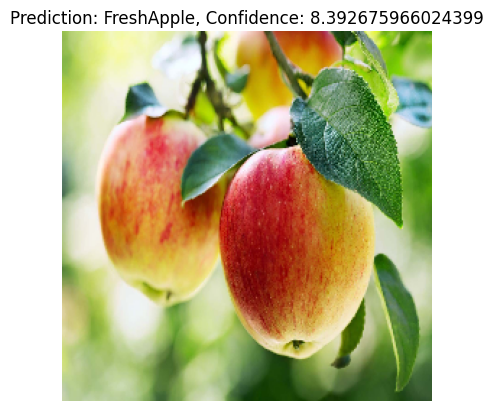

In [35]:
def testModelNewImg(url, name):
    fruit_path = tf.keras.utils.get_file(name, origin=url)

    img = tf.keras.utils.load_img(
        fruit_path, target_size=(256, 256)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = fruitFreshnessModel.predict(img_array)
    score = tf.nn.softmax(predictions)

    plt.imshow(img)
    plt.title(f'Prediction: {classNames[np.argmax(score)]}, Confidence: {100 * np.max(score)}')
    plt.axis("off")

freshApple = "https://as1.ftcdn.net/v2/jpg/02/10/59/70/1000_F_210597040_wxyvT8wGl322pfG6xO4LGW4FCWTgkOyX.jpg"
rottenApple = "https://i0.wp.com/writemakesmight.net/wp-content/uploads/2020/05/rotten-apple-13258722.jpg?fit=800%2C883&ssl=1&w=640"
rottenBanana = "https://media.istockphoto.com/id/539370180/photo/rotten-banana.jpg?s=612x612&w=0&k=20&c=bj_rIJP3jxYgma2G5sJmu7-3nlh-s21LNcVZbDfyGBI="
freshBanana = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ7My_XR9XHzWHFrq3LJ_X1Kq0hbu8CtD2yzQ&usqp=CAU"

freshApple2 = "https://cdn.britannica.com/22/187222-050-07B17FB6/apples-on-a-tree-branch.jpg"

# testModelNewImg(freshApple, 'freshApple1')
# testModelNewImg(rottenApple, 'rottenApple1')
# testModelNewImg(rottenBanana, 'rottenBanana1')
# testModelNewImg(freshBanana, 'freshBanana1')
testModelNewImg(freshApple2, 'freshApple2')



# Store Model

In [32]:
H5_StorePath = ProjPath.joinpath('Models/fruitFreshnessModel.h5')
TF_StorePath = ProjPath.joinpath('Models/fruitFreshnessModel.tf')
nativeKeras_StorePath = ProjPath.joinpath('Models/fruitFreshnessModel.keras')

tf.keras.saving.save_model(fruitFreshnessModel, H5_StorePath, save_format='h5')
tf.keras.saving.save_model(fruitFreshnessModel, TF_StorePath, save_format='tf')
tf.keras.saving.save_model(fruitFreshnessModel, nativeKeras_StorePath, save_format='keras')

/tmp/ipykernel_1555297/971845347.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.saving.save_model(fruitFreshnessModel, H5_StorePath, save_format='h5')


INFO:tensorflow:Assets written to: Models/fruitFreshnessModel.tf/assets


INFO:tensorflow:Assets written to: Models/fruitFreshnessModel.tf/assets
